In [1]:
import pandas as pd
%matplotlib inline

In [2]:
train_data = pd.read_csv('data/Train/Train.csv', low_memory=False)
test_data = pd.read_csv('data/Test.csv', low_memory=False)

In [3]:
data = pd.concat([train_data, test_data])

In [4]:
print(len(train_data.index), len(test_data.index))

75278 35249


In [5]:
len(data.index)

110527

In [6]:
first_camp = pd.read_csv('data/Train/First_Health_Camp_Attended.csv', low_memory=False)

In [7]:
second_camp = pd.read_csv('data/Train/Second_Health_Camp_Attended.csv', low_memory=False)

In [8]:
third_camp = pd.read_csv('data/Train/Third_Health_Camp_Attended.csv', low_memory=False)

In [9]:
cols = ['Patient_ID', 'Health_Camp_ID']
success = pd.concat([first_camp[cols], second_camp[cols], third_camp[cols]])

In [10]:
success['target'] = 1

In [11]:
target_data = pd.merge(data, success, on=cols, how='left')

In [12]:
target_data.target = target_data.target.replace(pd.np.nan, 0)

In [13]:
target_data.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,target
0,489652,6578,10-Sep-05,4,0,0,0,2,1.0
1,507246,6578,18-Aug-05,45,5,0,0,7,0.0
2,523729,6534,29-Apr-06,0,0,0,0,0,1.0
3,524931,6535,07-Feb-04,0,0,0,0,0,0.0
4,521364,6529,28-Feb-06,15,1,0,0,7,1.0


In [14]:
target_data.Registration_Date = target_data.Registration_Date.fillna(method='ffill')

In [15]:
target_data['day'] = target_data.Registration_Date.apply(lambda x: str(x).split('-')[0])
target_data['month'] = target_data.Registration_Date.apply(lambda x: str(x).split('-')[1])
target_data['year'] = target_data.Registration_Date.apply(lambda x: str(x).split('-')[2])

In [16]:
target_data.year.value_counts()

06    48324
05    36223
04    19117
07     3790
03     3073
Name: year, dtype: int64

In [17]:
months = {'jan': 1,
          'feb': 2,
          'mar': 3,
          'apr':4,
          'may':5,
          'jun':6,
          'jul':7,
          'aug':8,
          'sep':9,
          'oct':10,
          'nov':11,
          'dec':12}

target_data['month'] = target_data['month'].apply(lambda x: months[x.lower()])

In [18]:
target_data['day'] = target_data['day'].apply(int)
target_data['month'] = target_data['month'].apply(int)
target_data['year'] = target_data['year'].apply(lambda x: int('20'+x))

In [18]:
del target_data['Registration_Date']

In [21]:
len(train_data.index)

75278

In [89]:
trainset = target_data[0:len(train_data.index)]
testset = target_data[len(train_data.index):]

In [90]:
target_data.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5',
       'target', 'day', 'month', 'year'],
      dtype='object')

In [79]:
import xgboost as xgb

In [91]:
trainset.head()

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,target,day,month,year
0,489652,6578,4,0,0,0,2,1.0,10,9,2005
1,507246,6578,45,5,0,0,7,0.0,18,8,2005
2,523729,6534,0,0,0,0,0,1.0,29,4,2006
3,524931,6535,0,0,0,0,0,0.0,7,2,2004
4,521364,6529,15,1,0,0,7,1.0,28,2,2006


In [93]:
partial_trainset = trainset[trainset['year'].isin([2004, 20005])]
validation_set = trainset[trainset['year'] > 2005]

In [94]:
train_cols = [col for col in trainset.columns if col != 'target']
X_train = partial_trainset[train_cols]
Y_train = partial_trainset['target']

In [97]:
X_val = validation_set[train_cols]
Y_val = validation_set['target']

In [95]:
X_test = testset[train_cols]
Y_test = testset['target']

In [98]:
dtrain = xgb.DMatrix(X_train.as_matrix(), label=Y_train.as_matrix(), feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test.as_matrix(), label=Y_test.as_matrix(), feature_names=X_test.columns)
dval = xgb.DMatrix(X_val.as_matrix(), label=Y_val.as_matrix(), feature_names=X_val.columns)

In [99]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [104]:
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.01
params["min_child_weight"] = 1
params["subsample"] = 0.8
# params["colsample_bytree"] = 0.8
params["scale_pos_weight"] = 1.0
# params["silent"] = 1
params["max_depth"] = 5
params["nthread"] = 4
params["eval_metric"] = "auc"

In [106]:
num_rounds = 190
model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	train-auc:0.728758	eval-auc:0.553447
[1]	train-auc:0.732053	eval-auc:0.558962
[2]	train-auc:0.733473	eval-auc:0.577049
[3]	train-auc:0.734007	eval-auc:0.577584
[4]	train-auc:0.733304	eval-auc:0.577839
[5]	train-auc:0.741026	eval-auc:0.582921
[6]	train-auc:0.741081	eval-auc:0.582386
[7]	train-auc:0.741675	eval-auc:0.583355
[8]	train-auc:0.741525	eval-auc:0.587448
[9]	train-auc:0.744145	eval-auc:0.592517
[10]	train-auc:0.743324	eval-auc:0.590149
[11]	train-auc:0.743553	eval-auc:0.589929
[12]	train-auc:0.744511	eval-auc:0.593431
[13]	train-auc:0.746587	eval-auc:0.650419
[14]	train-auc:0.748532	eval-auc:0.653755
[15]	train-auc:0.748531	eval-auc:0.655839
[16]	train-auc:0.748888	eval-auc:0.650602
[17]	train-auc:0.749157	eval-auc:0.652170
[18]	train-auc:0.749585	eval-auc:0.652176
[19]	train-auc:0.749213	eval-auc:0.649242
[20]	train-auc:0.749476	eval-auc:0.627198
[21]	train-auc:0.749682	eval-auc:0.624890
[22]	train-auc:0.748773	eval-auc:0.622306
[23]	train-auc:0.748618	eval-auc:0.620883
[2

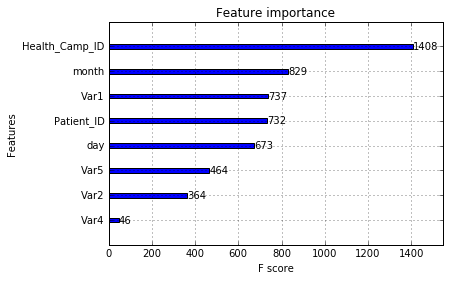

In [110]:
xgb.plot_importance(model)

In [112]:
predictions = model.predict(dtest)

In [117]:
submission = X_test[['Patient_ID', 'Health_Camp_ID']]

In [127]:
submission.reset_index().to_csv('submission_1.csv', index=False)

In [20]:
target_data.to_csv('trail1_data.csv', index=False)